In [0]:
#Importing all the required libraries and stuff

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')



In [0]:
print(keras.__version__)

2.1.5


In [0]:
train=pd.read_csv("/home/Shubham/Desktop/MNIST_KDAG/train.csv")
test=pd.read_csv("/home/Shubham/Desktop/MNIST_KDAG/test.csv")

In [0]:
print(train)

       label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
5          0       0       0       0       0       0       0       0       0   
6          7       0       0       0       0       0       0       0       0   
7          3       0       0       0       0       0       0       0       0   
8          5       0       0       0       0       0       0       0       0   
9          3       0       0       0       0       0       0       0       0   
10         8       0       0       0       0       0       0       0       0   
11         9       0       0       0    

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

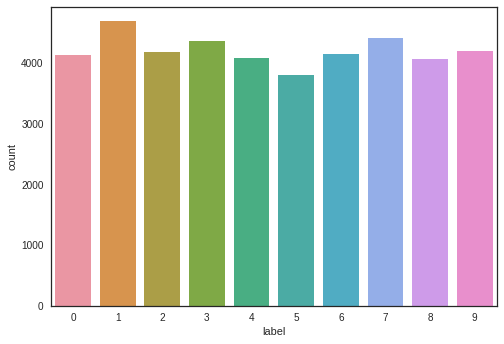

In [0]:
#Splitting the train data to input and response variable
Y_train=train["label"]
X_train=train.drop("label",axis=1)

"""Plotting the frequency of each label from 0-9, 
this is being done to ensure that the input dataset is not biased and thus preventing the model from
over-fitting certain digits,but here the set of labels are more or less balanced


"""
sns.countplot(Y_train)
Y_train.value_counts()

In [0]:
#Checking for null or corrupt values
X_train.isnull().any().describe()
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [0]:
#Normalizing the values as CNN would converge faster on [0,1] than [0,255]
X_train=X_train/255.0
test=test/255.0

In [0]:
"""Currently all of the training examples have been loaded as vectors of dimension 1x784.I intend to reshape it to a
28x28x1 3-D matrix.Keras requires an extra dimension in the end which corresponds to channels.
"""
X_train=X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

In [0]:
#Now i am encoding the label to vectors like 9->[0,0,0,0,0,0,0,0,0,1] number of classes being 10
Y_train=to_categorical(Y_train,num_classes=10)
print(to_categorical(2,10))

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


In [0]:
#Setting the random seed
random_seed=2

#Splitting the dataset to training and validation dataset
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.1,random_state=random_seed)


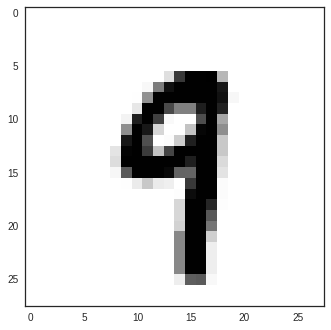

In [0]:
#Example of an Image
plt.imshow(X_train[2][:,:,0])

# Model Architechture Description
Now I am setting my CNN architechture. My CNN architechture is as follows->[[Conv2D->relu]x2 layers->MaxPool2D->Dropout(to drop some of the nodes and regularizing the model to reduce overfitting]x2->Flatten->Dense->Dropout


In [0]:
model=Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [0]:
#Now I would define my optimizer which is RMSprop with default
#values instead of Stochastic Gradient Descent to minize the cost function
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

#Compiling my model
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

# Setting the Learning rate

In order to, not have high learning rate and end up with non-convergence or have a low learning rate and have slow convergence to the global optimum.I used ReduceOnPlateau function from Keras.callbacks to reduce the learning rate by half if the accuracy is not improved after 3 epochs

In [0]:
#Setting the learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
epochs = 2
batch_size = 86

In [0]:
#Fitting the model with the training dataset
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, Y_val), verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/2
 - 527s - loss: 0.2382 - acc: 0.9237 - val_loss: 0.0690 - val_acc: 0.9800
Epoch 2/2
 - 549s - loss: 0.0743 - acc: 0.9778 - val_loss: 0.0691 - val_acc: 0.9810


In [0]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")


submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

